In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import copy

# generate transitions

#  these are fixed
transitions_0 = np.eye(4)
transitions_1 = np.zeros([4,4])
transitions_1[:,-1] = 0.1
transitions_1[-1,-1] = 0

#  these are the ones we want to learn
indices = np.array([[0,1],
                  [0,2],
                  [1,0],
                  [1,2],
                  [2,0],
                  [2,1],
                  [3,0],
                  [3,1]])


transitions_1[indices[:,0],indices[:,1]] = 0.45
transitions_1[3,2] = 0.1
transitions_1

transitions = {0: transitions_0,
               1: transitions_1}

transitions[0], transitions[1]

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]]))

In [2]:
def print_progress(states):
    for i in states.keys():
        print(i, states[i].progress, states[i].completed)
        
def get_active_states(states, return_ix=False):
    d = {}
    for s in states.keys():
        if not states[s].completed:
            d[s] =   states[s]
    if return_ix:
        return np.array(list(d.keys()))
    return d


#  Basic reward function
class Reward:
    def __init__(self, states, streaks, streak_length, streak_reward, So_p_reward=0.9):
        self.streaks = streaks
        self.streak_length = streak_length
        self.last_streak_init = 0
        self.states = states
        self.streak_reward = streak_reward
        self.So_p_reward = So_p_reward
        
    def __call__(self, current_state_ix, action_history, n_tasks_completed):
        state = self.states[current_state_ix]
        if action_history[-1]:
            self.last_streak_init = len(action_history)
            return -1

        # if we stay, we might get a reward    
        if state.state_length < 1000: # if we are in task state
            if state.completed: # if task completed, get big money!
                return 100**(n_tasks_completed) + (state.state_length)**2
            else: 
                if self.streaks and (current_state_ix != 3):
                    a = action_history[self.last_streak_init:self.last_streak_init+self.streak_length]
                    if (np.sum(a) == 0) and len(a) == self.streak_length:
                        self.last_streak_init = self.last_streak_init+self.streak_length
                        return self.streak_reward
                return -1
        else: # if we are in other state
            v = npr.binomial(1, self.So_p_reward) # return random reward
#             return 2*(1-v) - v
            return 2*(v) - (1-v)


        
        
# def reward(state, action_history):
#     # if we just switched, always penalize
#     if action_history[-1]:
#         return -1
    
#     # if we stay, we might get a reward    
#     if state.state_length < 1000: # if we are in task state
#         if state.completed: # if task completed, get big money!
#             return 100**(self.n_tasks_completed) + state.state_length
#         else: 
#             return -1
#     else: # if we are in other state
#         v = npr.binomial(1, 0.9) # return random reward
#         return 2*(1-v) - v

    



In [3]:
class Task_Timer:
    def __init__(self, states, on_break, max_decrement=30):
        self.states = states
        self.on_break = on_break
        self.max_decrement = max_decrement
        
    def step(self, current_state_ix, action):
        states = get_active_states(self.states)
        states_ix = get_active_states(self.states, True)
    
        if action: # if we switched, decrement progress of all active states
            for s in states.keys():
                if states[s].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[s].progress = max(0, states[s].progress -1)
                    states[s].n_decrement += 1
                
        else:
            states[current_state_ix].progress += 1 # increment progress on current state
            
            if states[current_state_ix].progress >= states[current_state_ix].state_length-1: 
                states[current_state_ix].completed = True
                
            
            s_ = np.setdiff1d(states_ix, current_state_ix)
            for i in s_:
                if states[i].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[i].progress = max(0, states[i].progress-1)
                    states[i].n_decrement += 1
                

            
            
            
        

In [477]:
import numpy.random as npr
import numpy as np

class State:
    def __init__(self, state_length):
        self.state_length = state_length
        self.progress = 0
        self.completed = False
        self.n_decrement = 0

class MDP:
    def __init__(self, 
                 reward, 
                 task_timer, 
                 transitions, 
                 init_state=None, 
                 Break = False, 
                 break_length = 15,
                 Streaks = True, 
                 streak_length = 10,
                 streak_reward = 10,
                 So_reward_p = 0.1):
        '''
        transitions: ()
        init_state: (int)
        '''
        
        # Time Horizon is 8 hours
        self.T = 60*8 
        
        # init states
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        self.init_state = init_state
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
        self.init_s = self.current_state_ix
        
        
        self.init_transition = transitions    
        self.transitions = copy.deepcopy(transitions)
        self.n_tasks_completed = 0
        self.tasks_completed = []
        
        self.Break = Break
        self.on_break = False
        self.break_counter = 0
        self.break_length = break_length
        
        self.task_timer = task_timer(self.states, self.on_break)
        
        
        self.Streaks = Streaks
        self.streak_length = streak_length
        self.streak_reward = streak_reward
        self.So_reward_p = So_reward_p

        self.reward = reward
        self.reward_fn = self.reward(self.states, 
                                self.Streaks, 
                                self.streak_length,
                               self.streak_reward,
                               self.So_reward_p)
        
        self.action_history = []
    
    def __call__(self, action):
        '''Take a step 
        0 is stay
        1 is transition'''
        self.action_history.append(action)
        if action:
            if self.on_break:
                self.on_break = False
                self.task_timer.on_break = False
            # get candidate transitions and probabilities
#             s = get_active_states(self.states, True)
            s = np.setdiff1d(get_active_states(self.states, True),3)
#             self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            norm = 1- self.transitions[1][self.current_state_ix,3].sum()                    
            n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#             if np.isnan(n).max():
#                 return "ERROR"
            self.transitions[1][self.current_state_ix,s] = n
            n = len(self.transitions[1])
            self.transitions[1][np.arange(n), np.arange(n)] = 0
            
            s = get_active_states(self.states, True)
            p=self.transitions[1][self.current_state_ix, s]
            
#             print(s, p)
            # reset n_decrement
            self.states[self.current_state_ix].n_decrement = 0
            

        
            # randomly sample
            self.current_state_ix = npr.choice(s, p=normalize(p)    )
        else:
            if self.on_break and self.current_state_ix == 3:
                self.break_counter += 1
            
                if self.break_counter >= self.break_length: 
                    # done with break
                    s = np.setdiff1d(get_active_states(self.states, True),3)
#                     self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
                    norm = 1- self.transitions[1][self.current_state_ix,3].sum()
    
                    n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#                     if np.isnan(n).max():
#                         return "ERROR"
                    self.transitions[1][self.current_state_ix,s] = n
                    n = len(self.transitions[1])
                    self.transitions[1][np.arange(n), np.arange(n)] = 0
                    
                    s = get_active_states(self.states, True)
                    p=self.transitions[1][self.current_state_ix, s]
#                     print(s, p)

                    
                    
                    self.current_state_ix = npr.choice(s, p=normalize(p))    
                    self.on_break = False
                    self.task_timer.on_break = False
                    
            pass
        
        self.task_timer.step(self.current_state_ix, action)          
        r = self.reward_fn(self.current_state_ix, self.action_history, self.n_tasks_completed)
        
        # if we complete the task, sample a new task
        if self.states[self.current_state_ix].completed:
            self.tasks_completed.append(self.current_state_ix)
#             s = get_active_states(self.states, True)
            s = np.setdiff1d(get_active_states(self.states, True),3)
#             self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            norm = 1- self.transitions[1][self.current_state_ix,3].sum()
            n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#             if np.isnan(n).max():
#                 return "ERROR"
            
            self.transitions[1][self.current_state_ix,s] = n
            n = len(self.transitions[1])
            self.transitions[1][np.arange(n), np.arange(n)] = 0
            
            s = get_active_states(self.states, True)
            p = self.transitions[1][self.current_state_ix,s]
            
#             print(s, p)
            self.current_state_ix = npr.choice(s, p=normalize(p))
            self.n_tasks_completed += 1
            
            
            
            if self.Break:
                self.current_state_ix = 3
                self.on_break = True
                self.task_timer.on_break = True
                self.break_counter = 0
                
            
        self.total_reward += r
        return self.current_state_ix, r
    
    def get_state_ix(self):
        return self.current_state_ix
    
    def get_state(self):
        return self.states[self.current_state_ix]
    
    def reset(self):
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
        
        self.init_s = self.current_state_ix
            
        self.transitions = copy.deepcopy(self.init_transition)
        self.n_tasks_completed = 0
        self.action_history = []
        
        self.on_break = False
        
        self.task_timer.states = self.states
        self.task_timer.on_break = self.on_break
        
        self.reward_fn.states = self.states
        self.tasks_completed = []


        
# def normalize(p):
#     return p/p.sum()

def normalize(p, norm=1):
#     p_ = p[:-1]
#     return p_/p_.sum()*(1-p[-1])
    return p/p.sum()*norm

def fake_agent(s, r):
    # random action
    return npr.choice(2, p=[0.99, 0.01])


mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          None, 
          Break=False, 
          Streaks=False)
self = mdp
    
    

    
        
        

In [483]:
class Agent:
    def __init__(self, 
                 discount_factor = 0.9,
                 learning_rate = 0.9,
                 weight_1 = 0.2, 
                 weight_2 = 0.1, 
                 weight_3 = 0.2,
                 weight_4 = 0.1,
                 a = 0,
                 epsilon = 0.05):
        
        self.Qn = npr.randn(4, 2)*0.01
        self.Qp = npr.randn(4, 2)*0.01
        self.Q = np.zeros((4, 2))

        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_3 = weight_3
        self.weight_4 = weight_4
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.a = 0
        
        self.epsilon = epsilon
        

#     def choose_action(self, s, r):
#         s_idx = mdp.get_state_ix()
        
#         # TODO: check that not all states are complete
#         self.Q[s_idx, self.a] = self.weight_2 * self.Qp[s_idx, self.a] + self.weight_4 * self.Qn[s_idx, self.a]
#         self.a = np.argmax(self.Q[s_idx])
#         new_s,_ = mdp(self.a)
#         new_s_idx = mdp.get_state_ix()

#         self.Qp[s_idx, self.a] = self.weight_1 * self.Qp[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[new_s_idx]) - self.Qp[s_idx, self.a])
#         self.Qn[s_idx, self.a] = self.weight_3 * self.Qn[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[new_s_idx]) - self.Qn[s_idx, self.a])

#         return np.argmax(self.Q[s_idx]) 
    
    def choose_action(self, s_idx):
        p = np.random.random()
        if p < self.epsilon:
          return np.random.choice([0,1]) 
        else:
          return np.argmax(self.Q[s_idx])
        
    def update(self, s0_idx, s1_idx, r):
        
        # TODO: check that not all states are complete
        self.Q[s0_idx, self.a] = self.weight_2 * self.Qp[s0_idx, self.a] + self.weight_4 * self.Qn[s0_idx, self.a]
        
        self.a = np.argmax(self.Q[s0_idx])

        if r > 0: 
            self.Qp[s0_idx, self.a] = self.weight_1 * self.Qp[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[s1_idx]) - self.Qp[s0_idx, self.a])
        else:
            self.Qn[s0_idx, self.a] = self.weight_3 * self.Qn[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[s1_idx]) - self.Qn[s0_idx, self.a])
        
    def reset(self,):
        self.Qn = npr.random((4, 2))*0.1
        self.Qp = npr.random((4, 2))*0.1
        self.a = 0
        self.Q = npr.random((4, 2))

In [484]:
class Episodes:
    def __init__(self, mdp, agent, n_episodes, verbose=True):
        self.mdp = mdp
        self.agent = agent
        self.EPISODES_NUM = n_episodes
        self.prog = [[] for _ in range(self.EPISODES_NUM)]
        self.actions = [[] for _ in range(self.EPISODES_NUM)]
        self.states = [[] for _ in range(self.EPISODES_NUM)]
        self.rewards = [[] for _ in range(self.EPISODES_NUM)]
        self.on_break = [[] for _ in range(self.EPISODES_NUM)]
        self.score = [[] for _ in range(self.EPISODES_NUM)]
        self.tasks_completed = [[] for _ in range(self.EPISODES_NUM)]
        self.init_states = [[] for _ in range(self.EPISODES_NUM)]
        self.time_horizon = 480
        
        self.verbose= verbose
        
        
    def run(self, ):
        if self.verbose:
            print(f"Running {self.EPISODES_NUM} episodes")
        for i in range(self.EPISODES_NUM):
            self.mdp.reset() # reset mdp for every episode
#             self.agent.reset() # reset agent for every episode
            
            
            s0 = self.mdp.get_state_ix()
            for j in range(self.time_horizon):

                a = self.agent.choose_action(s0)
                s1, r = self.mdp(a)
                s1 = self.mdp.get_state_ix()
                self.agent.update(s0, s1, r)
                s0 = s1

                p_ = [mdp.states[k].progress for k in range(4)]

                self.prog[i].append(p_)
                self.actions[i].append(a)
                self.states[i].append(self.mdp.current_state_ix)
                self.rewards[i].append(r)
                self.on_break[i].append(self.mdp.on_break)
                

                active_states = get_active_states(self.mdp.states,True)
                if len(active_states) == 1:
                    break
#             print(self.mdp.transitions)
            self.init_states[i].append(self.mdp.init_s)
            self.tasks_completed[i].append(self.mdp.tasks_completed)
                    
            self.score[i] = np.sum(self.rewards[i])
            if self.verbose:
                print(f"\tEpisode: {i}\tScore: {self.score[i]}")

In [308]:
episode.mdp.transitions

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.        , 0.45      , 0.45      , 0.1       ],
        [0.45      ,        nan, 0.9       , 0.1       ],
        [0.45      , 0.9       , 0.        , 0.1       ],
        [0.45      , 1.        , 0.18181818, 0.        ]])}

## Bar plot 1: tasks completed per setting

In [59]:
def get_bary(episode):
    bary = np.zeros(3)
    
    x = np.concatenate([i[0] for i in episode.tasks_completed if len(i[0]) > 0])

    u, c = np.unique(x, return_counts=True)
    o = np.setdiff1d(np.arange(3), u)


    for i,j  in zip(u, c):
        bary[i] = j

    for i in o:
        bary[i] = 0
        
    return bary


In [116]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.15) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary1 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -447
	Episode: 2	Score: -397
	Episode: 3	Score: -465
	Episode: 4	Score: -379
	Episode: 5	Score: -450
	Episode: 6	Score: -382
	Episode: 7	Score: -134
	Episode: 8	Score: -441
	Episode: 9	Score: -167
	Episode: 10	Score: -409
	Episode: 11	Score: -465
	Episode: 12	Score: -447
	Episode: 13	Score: -474
	Episode: 14	Score: -453
	Episode: 15	Score: -438
	Episode: 16	Score: -441
	Episode: 17	Score: -334
	Episode: 18	Score: -453
	Episode: 19	Score: -477
	Episode: 20	Score: -465
	Episode: 21	Score: -477
	Episode: 22	Score: -462
	Episode: 23	Score: -450
	Episode: 24	Score: -447
	Episode: 25	Score: -462
	Episode: 26	Score: -450
	Episode: 27	Score: -471
	Episode: 28	Score: -465
	Episode: 29	Score: -471
	Episode: 30	Score: -477
	Episode: 31	Score: -459
	Episode: 32	Score: -450
	Episode: 33	Score: -471
	Episode: 34	Score: -474
	Episode: 35	Score: -462
	Episode: 36	Score: -325
	Episode: 37	Score: -441
	Episode: 38	Score: -465
	Episode: 39	

	Episode: 328	Score: -456
	Episode: 329	Score: -474
	Episode: 330	Score: -459
	Episode: 331	Score: -477
	Episode: 332	Score: -462
	Episode: 333	Score: -441
	Episode: 334	Score: -468
	Episode: 335	Score: -480
	Episode: 336	Score: -468
	Episode: 337	Score: -471
	Episode: 338	Score: -477
	Episode: 339	Score: -450
	Episode: 340	Score: -468
	Episode: 341	Score: -462
	Episode: 342	Score: -474
	Episode: 343	Score: -471
	Episode: 344	Score: -465
	Episode: 345	Score: -468
	Episode: 346	Score: -456
	Episode: 347	Score: -432
	Episode: 348	Score: -459
	Episode: 349	Score: -480
	Episode: 350	Score: -355
	Episode: 351	Score: -465
	Episode: 352	Score: -465
	Episode: 353	Score: -456
	Episode: 354	Score: -444
	Episode: 355	Score: -450
	Episode: 356	Score: -465
	Episode: 357	Score: -474
	Episode: 358	Score: -444
	Episode: 359	Score: -468
	Episode: 360	Score: -435
	Episode: 361	Score: -462
	Episode: 362	Score: -465
	Episode: 363	Score: -465
	Episode: 364	Score: -474
	Episode: 365	Score: -477
	Episode: 36

	Episode: 654	Score: -456
	Episode: 655	Score: -480
	Episode: 656	Score: -462
	Episode: 657	Score: -450
	Episode: 658	Score: -477
	Episode: 659	Score: -447
	Episode: 660	Score: -471
	Episode: 661	Score: -477
	Episode: 662	Score: -468
	Episode: 663	Score: -459
	Episode: 664	Score: -465
	Episode: 665	Score: -480
	Episode: 666	Score: -471
	Episode: 667	Score: -441
	Episode: 668	Score: -474
	Episode: 669	Score: -453
	Episode: 670	Score: -456
	Episode: 671	Score: -462
	Episode: 672	Score: -456
	Episode: 673	Score: -462
	Episode: 674	Score: -444
	Episode: 675	Score: -453
	Episode: 676	Score: -453
	Episode: 677	Score: -456
	Episode: 678	Score: -450
	Episode: 679	Score: -474
	Episode: 680	Score: -474
	Episode: 681	Score: -349
	Episode: 682	Score: -465
	Episode: 683	Score: -459
	Episode: 684	Score: -474
	Episode: 685	Score: -477
	Episode: 686	Score: -459
	Episode: 687	Score: -471
	Episode: 688	Score: -471
	Episode: 689	Score: -462
	Episode: 690	Score: -441
	Episode: 691	Score: -468
	Episode: 69

	Episode: 978	Score: -474
	Episode: 979	Score: -343
	Episode: 980	Score: -474
	Episode: 981	Score: -468
	Episode: 982	Score: -462
	Episode: 983	Score: -465
	Episode: 984	Score: -462
	Episode: 985	Score: -474
	Episode: 986	Score: -474
	Episode: 987	Score: -450
	Episode: 988	Score: -444
	Episode: 989	Score: -459
	Episode: 990	Score: -462
	Episode: 991	Score: -337
	Episode: 992	Score: -441
	Episode: 993	Score: -459
	Episode: 994	Score: -447
	Episode: 995	Score: -471
	Episode: 996	Score: -477
	Episode: 997	Score: -331
	Episode: 998	Score: -465
	Episode: 999	Score: -456


In [119]:
bary2

array([  0., 236., 412.])

In [118]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary2 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -238
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -358
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -14
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -358
	Episode: 25	Score: -358
	Episode: 26	Score: -238
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -238
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	S

	Episode: 327	Score: -480
	Episode: 328	Score: -17
	Episode: 329	Score: -480
	Episode: 330	Score: -480
	Episode: 331	Score: -480
	Episode: 332	Score: -480
	Episode: 333	Score: -480
	Episode: 334	Score: -358
	Episode: 335	Score: -480
	Episode: 336	Score: -480
	Episode: 337	Score: -355
	Episode: 338	Score: -358
	Episode: 339	Score: -480
	Episode: 340	Score: -358
	Episode: 341	Score: -480
	Episode: 342	Score: -480
	Episode: 343	Score: -480
	Episode: 344	Score: -358
	Episode: 345	Score: -480
	Episode: 346	Score: -358
	Episode: 347	Score: -480
	Episode: 348	Score: -358
	Episode: 349	Score: -480
	Episode: 350	Score: -480
	Episode: 351	Score: -358
	Episode: 352	Score: -480
	Episode: 353	Score: -480
	Episode: 354	Score: -358
	Episode: 355	Score: -480
	Episode: 356	Score: -480
	Episode: 357	Score: -480
	Episode: 358	Score: -358
	Episode: 359	Score: -480
	Episode: 360	Score: -480
	Episode: 361	Score: -480
	Episode: 362	Score: -17
	Episode: 363	Score: -480
	Episode: 364	Score: -480
	Episode: 365	

	Episode: 645	Score: -238
	Episode: 646	Score: -235
	Episode: 647	Score: -238
	Episode: 648	Score: -238
	Episode: 649	Score: -238
	Episode: 650	Score: -238
	Episode: 651	Score: -238
	Episode: 652	Score: -238
	Episode: 653	Score: -238
	Episode: 654	Score: -480
	Episode: 655	Score: -238
	Episode: 656	Score: -238
	Episode: 657	Score: -238
	Episode: 658	Score: -238
	Episode: 659	Score: -238
	Episode: 660	Score: -238
	Episode: 661	Score: -238
	Episode: 662	Score: -238
	Episode: 663	Score: -238
	Episode: 664	Score: -238
	Episode: 665	Score: -238
	Episode: 666	Score: -238
	Episode: 667	Score: -238
	Episode: 668	Score: -238
	Episode: 669	Score: -238
	Episode: 670	Score: -238
	Episode: 671	Score: -238
	Episode: 672	Score: -238
	Episode: 673	Score: -238
	Episode: 674	Score: -238
	Episode: 675	Score: -238
	Episode: 676	Score: -238
	Episode: 677	Score: -235
	Episode: 678	Score: -238
	Episode: 679	Score: -238
	Episode: 680	Score: -238
	Episode: 681	Score: -238
	Episode: 682	Score: -235
	Episode: 68

	Episode: 963	Score: -238
	Episode: 964	Score: -238
	Episode: 965	Score: -235
	Episode: 966	Score: -238
	Episode: 967	Score: -238
	Episode: 968	Score: -238
	Episode: 969	Score: -238
	Episode: 970	Score: -238
	Episode: 971	Score: -238
	Episode: 972	Score: -238
	Episode: 973	Score: -235
	Episode: 974	Score: -238
	Episode: 975	Score: -238
	Episode: 976	Score: -238
	Episode: 977	Score: -235
	Episode: 978	Score: -238
	Episode: 979	Score: -238
	Episode: 980	Score: -235
	Episode: 981	Score: -238
	Episode: 982	Score: -238
	Episode: 983	Score: -238
	Episode: 984	Score: -238
	Episode: 985	Score: -238
	Episode: 986	Score: -238
	Episode: 987	Score: -235
	Episode: 988	Score: -238
	Episode: 989	Score: -238
	Episode: 990	Score: -238
	Episode: 991	Score: -238
	Episode: 992	Score: -238
	Episode: 993	Score: -238
	Episode: 994	Score: -238
	Episode: 995	Score: -238
	Episode: 996	Score: -238
	Episode: 997	Score: -238
	Episode: 998	Score: -238
	Episode: 999	Score: -238


In [145]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=True,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary3 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: 180
	Episode: 1	Score: -161
	Episode: 2	Score: -11
	Episode: 3	Score: -139
	Episode: 4	Score: -22
	Episode: 5	Score: -33
	Episode: 6	Score: -88
	Episode: 7	Score: -128
	Episode: 8	Score: -95
	Episode: 9	Score: -33
	Episode: 10	Score: -99
	Episode: 11	Score: -128
	Episode: 12	Score: -66
	Episode: 13	Score: -106
	Episode: 14	Score: -128
	Episode: 15	Score: 5
	Episode: 16	Score: -11
	Episode: 17	Score: -77
	Episode: 18	Score: -139
	Episode: 19	Score: -73
	Episode: 20	Score: 177
	Episode: 21	Score: -117
	Episode: 22	Score: 111
	Episode: 23	Score: -95
	Episode: 24	Score: -128
	Episode: 25	Score: -106
	Episode: 26	Score: -95
	Episode: 27	Score: -139
	Episode: 28	Score: -33
	Episode: 29	Score: 11
	Episode: 30	Score: -117
	Episode: 31	Score: -44
	Episode: 32	Score: -44
	Episode: 33	Score: -22
	Episode: 34	Score: -139
	Episode: 35	Score: 199
	Episode: 36	Score: -55
	Episode: 37	Score: 210
	Episode: 38	Score: -44
	Episode: 39	Score: -11
	Episode: 40	Score

	Episode: 338	Score: -73
	Episode: 339	Score: -22
	Episode: 340	Score: -150
	Episode: 341	Score: 0
	Episode: 342	Score: -62
	Episode: 343	Score: -150
	Episode: 344	Score: 188
	Episode: 345	Score: 22
	Episode: 346	Score: -117
	Episode: 347	Score: -22
	Episode: 348	Score: 38
	Episode: 349	Score: -22
	Episode: 350	Score: -62
	Episode: 351	Score: -117
	Episode: 352	Score: -66
	Episode: 353	Score: -50
	Episode: 354	Score: -44
	Episode: 355	Score: -77
	Episode: 356	Score: 177
	Episode: 357	Score: 221
	Episode: 358	Score: -95
	Episode: 359	Score: -106
	Episode: 360	Score: -183
	Episode: 361	Score: -172
	Episode: 362	Score: -11
	Episode: 363	Score: 188
	Episode: 364	Score: -33
	Episode: 365	Score: -62
	Episode: 366	Score: -11
	Episode: 367	Score: -11
	Episode: 368	Score: -128
	Episode: 369	Score: -55
	Episode: 370	Score: -139
	Episode: 371	Score: 16
	Episode: 372	Score: -44
	Episode: 373	Score: -44
	Episode: 374	Score: -66
	Episode: 375	Score: -55
	Episode: 376	Score: 60
	Episode: 377	Score: -

	Episode: 672	Score: -117
	Episode: 673	Score: 199
	Episode: 674	Score: -139
	Episode: 675	Score: 11
	Episode: 676	Score: -33
	Episode: 677	Score: -172
	Episode: 678	Score: -110
	Episode: 679	Score: -84
	Episode: 680	Score: 0
	Episode: 681	Score: -55
	Episode: 682	Score: -95
	Episode: 683	Score: -84
	Episode: 684	Score: 16
	Episode: 685	Score: 16
	Episode: 686	Score: -77
	Episode: 687	Score: -22
	Episode: 688	Score: -73
	Episode: 689	Score: 0
	Episode: 690	Score: -106
	Episode: 691	Score: -3
	Episode: 692	Score: 155
	Episode: 693	Score: -55
	Episode: 694	Score: -132
	Episode: 695	Score: -66
	Episode: 696	Score: -73
	Episode: 697	Score: -84
	Episode: 698	Score: -33
	Episode: 699	Score: -106
	Episode: 700	Score: 100
	Episode: 701	Score: -77
	Episode: 702	Score: -33
	Episode: 703	Score: -121
	Episode: 704	Score: -55
	Episode: 705	Score: -128
	Episode: 706	Score: -205
	Episode: 707	Score: -73
	Episode: 708	Score: -84
	Episode: 709	Score: -128
	Episode: 710	Score: -44
	Episode: 711	Score: -

In [146]:
bary3

array([494., 154.,   2.])

In [141]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 0

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary4 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: -409
	Episode: 1	Score: -468
	Episode: 2	Score: -385
	Episode: 3	Score: -415
	Episode: 4	Score: -474
	Episode: 5	Score: -462
	Episode: 6	Score: -376
	Episode: 7	Score: -391
	Episode: 8	Score: -400
	Episode: 9	Score: -394
	Episode: 10	Score: -400
	Episode: 11	Score: -468
	Episode: 12	Score: -462
	Episode: 13	Score: -480
	Episode: 14	Score: -468
	Episode: 15	Score: -409
	Episode: 16	Score: -474
	Episode: 17	Score: -456
	Episode: 18	Score: -435
	Episode: 19	Score: -403
	Episode: 20	Score: -462
	Episode: 21	Score: -432
	Episode: 22	Score: -355
	Episode: 23	Score: -367
	Episode: 24	Score: -465
	Episode: 25	Score: -403
	Episode: 26	Score: -409
	Episode: 27	Score: -388
	Episode: 28	Score: -453
	Episode: 29	Score: -456
	Episode: 30	Score: -385
	Episode: 31	Score: -409
	Episode: 32	Score: -385
	Episode: 33	Score: -453
	Episode: 34	Score: -468
	Episode: 35	Score: -415
	Episode: 36	Score: -382
	Episode: 37	Score: -409
	Episode: 38	Score: -468
	Episode: 39	

	Episode: 321	Score: -459
	Episode: 322	Score: -220
	Episode: 323	Score: -444
	Episode: 324	Score: -441
	Episode: 325	Score: -435
	Episode: 326	Score: -441
	Episode: 327	Score: -447
	Episode: 328	Score: -456
	Episode: 329	Score: -459
	Episode: 330	Score: -441
	Episode: 331	Score: -450
	Episode: 332	Score: -456
	Episode: 333	Score: -417
	Episode: 334	Score: -462
	Episode: 335	Score: -393
	Episode: 336	Score: -444
	Episode: 337	Score: -450
	Episode: 338	Score: -444
	Episode: 339	Score: -453
	Episode: 340	Score: -462
	Episode: 341	Score: -450
	Episode: 342	Score: -456
	Episode: 343	Score: -217
	Episode: 344	Score: -474
	Episode: 345	Score: -468
	Episode: 346	Score: -459
	Episode: 347	Score: -432
	Episode: 348	Score: -450
	Episode: 349	Score: -471
	Episode: 350	Score: -456
	Episode: 351	Score: -453
	Episode: 352	Score: -462
	Episode: 353	Score: -453
	Episode: 354	Score: -474
	Episode: 355	Score: -450
	Episode: 356	Score: -450
	Episode: 357	Score: -450
	Episode: 358	Score: -211
	Episode: 35

	Episode: 642	Score: -453
	Episode: 643	Score: -429
	Episode: 644	Score: -465
	Episode: 645	Score: -408
	Episode: 646	Score: -450
	Episode: 647	Score: -232
	Episode: 648	Score: -450
	Episode: 649	Score: -226
	Episode: 650	Score: -226
	Episode: 651	Score: -441
	Episode: 652	Score: -408
	Episode: 653	Score: -456
	Episode: 654	Score: -462
	Episode: 655	Score: -411
	Episode: 656	Score: -220
	Episode: 657	Score: -444
	Episode: 658	Score: -468
	Episode: 659	Score: -453
	Episode: 660	Score: -444
	Episode: 661	Score: -435
	Episode: 662	Score: -441
	Episode: 663	Score: -465
	Episode: 664	Score: -471
	Episode: 665	Score: -426
	Episode: 666	Score: -474
	Episode: 667	Score: -426
	Episode: 668	Score: -471
	Episode: 669	Score: -414
	Episode: 670	Score: -459
	Episode: 671	Score: -468
	Episode: 672	Score: -456
	Episode: 673	Score: -459
	Episode: 674	Score: -414
	Episode: 675	Score: -465
	Episode: 676	Score: -468
	Episode: 677	Score: -441
	Episode: 678	Score: -459
	Episode: 679	Score: -477
	Episode: 68

	Episode: 966	Score: -441
	Episode: 967	Score: -441
	Episode: 968	Score: -435
	Episode: 969	Score: -441
	Episode: 970	Score: -459
	Episode: 971	Score: -208
	Episode: 972	Score: -232
	Episode: 973	Score: -447
	Episode: 974	Score: -447
	Episode: 975	Score: -462
	Episode: 976	Score: -447
	Episode: 977	Score: -459
	Episode: 978	Score: -450
	Episode: 979	Score: -450
	Episode: 980	Score: -438
	Episode: 981	Score: -423
	Episode: 982	Score: -426
	Episode: 983	Score: -468
	Episode: 984	Score: -465
	Episode: 985	Score: -465
	Episode: 986	Score: -462
	Episode: 987	Score: -447
	Episode: 988	Score: -211
	Episode: 989	Score: -453
	Episode: 990	Score: -456
	Episode: 991	Score: -444
	Episode: 992	Score: -459
	Episode: 993	Score: -432
	Episode: 994	Score: -447
	Episode: 995	Score: -444
	Episode: 996	Score: -447
	Episode: 997	Score: -429
	Episode: 998	Score: -444
	Episode: 999	Score: -450


In [168]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 0

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=True,
         streak_length=10)

agent = Agent(epsilon=0.10) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary5 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: -86
	Episode: 1	Score: -64
	Episode: 2	Score: -87
	Episode: 3	Score: -76
	Episode: 4	Score: -200
	Episode: 5	Score: -165
	Episode: 6	Score: -217
	Episode: 7	Score: -111
	Episode: 8	Score: -179
	Episode: 9	Score: -152
	Episode: 10	Score: -205
	Episode: 11	Score: -120
	Episode: 12	Score: -113
	Episode: 13	Score: -235
	Episode: 14	Score: -206
	Episode: 15	Score: -208
	Episode: 16	Score: -104
	Episode: 17	Score: -75
	Episode: 18	Score: -39
	Episode: 19	Score: -139
	Episode: 20	Score: -106
	Episode: 21	Score: -125
	Episode: 22	Score: -103
	Episode: 23	Score: -152
	Episode: 24	Score: -98
	Episode: 25	Score: -54
	Episode: 26	Score: -81
	Episode: 27	Score: -46
	Episode: 28	Score: -111
	Episode: 29	Score: -102
	Episode: 30	Score: -116
	Episode: 31	Score: 250
	Episode: 32	Score: -98
	Episode: 33	Score: -167
	Episode: 34	Score: -126
	Episode: 35	Score: -154
	Episode: 36	Score: -172
	Episode: 37	Score: -167
	Episode: 38	Score: -45
	Episode: 39	Score: -153
	

	Episode: 332	Score: -119
	Episode: 333	Score: -146
	Episode: 334	Score: -181
	Episode: 335	Score: -93
	Episode: 336	Score: -153
	Episode: 337	Score: -116
	Episode: 338	Score: -175
	Episode: 339	Score: -105
	Episode: 340	Score: -187
	Episode: 341	Score: -171
	Episode: 342	Score: -76
	Episode: 343	Score: -127
	Episode: 344	Score: -163
	Episode: 345	Score: -105
	Episode: 346	Score: -126
	Episode: 347	Score: -77
	Episode: 348	Score: -69
	Episode: 349	Score: -65
	Episode: 350	Score: -143
	Episode: 351	Score: -243
	Episode: 352	Score: -138
	Episode: 353	Score: -77
	Episode: 354	Score: -77
	Episode: 355	Score: -77
	Episode: 356	Score: -77
	Episode: 357	Score: -144
	Episode: 358	Score: -144
	Episode: 359	Score: -123
	Episode: 360	Score: -94
	Episode: 361	Score: -95
	Episode: 362	Score: -144
	Episode: 363	Score: -67
	Episode: 364	Score: -30
	Episode: 365	Score: -68
	Episode: 366	Score: -163
	Episode: 367	Score: -135
	Episode: 368	Score: -114
	Episode: 369	Score: -160
	Episode: 370	Score: 292
	

	Episode: 656	Score: -171
	Episode: 657	Score: -54
	Episode: 658	Score: -184
	Episode: 659	Score: -188
	Episode: 660	Score: -122
	Episode: 661	Score: -197
	Episode: 662	Score: -142
	Episode: 663	Score: -158
	Episode: 664	Score: 275
	Episode: 665	Score: -68
	Episode: 666	Score: -98
	Episode: 667	Score: -61
	Episode: 668	Score: -114
	Episode: 669	Score: -94
	Episode: 670	Score: -162
	Episode: 671	Score: -79
	Episode: 672	Score: -118
	Episode: 673	Score: -72
	Episode: 674	Score: -141
	Episode: 675	Score: -83
	Episode: 676	Score: -146
	Episode: 677	Score: -82
	Episode: 678	Score: 169
	Episode: 679	Score: 306
	Episode: 680	Score: -123
	Episode: 681	Score: -167
	Episode: 682	Score: -71
	Episode: 683	Score: -125
	Episode: 684	Score: -73
	Episode: 685	Score: -84
	Episode: 686	Score: -146
	Episode: 687	Score: -38
	Episode: 688	Score: -120
	Episode: 689	Score: -142
	Episode: 690	Score: -120
	Episode: 691	Score: 225
	Episode: 692	Score: -24
	Episode: 693	Score: -67
	Episode: 694	Score: -74
	Episo

	Episode: 983	Score: 280
	Episode: 984	Score: -43
	Episode: 985	Score: -125
	Episode: 986	Score: -163
	Episode: 987	Score: -110
	Episode: 988	Score: -32
	Episode: 989	Score: -72
	Episode: 990	Score: -71
	Episode: 991	Score: -153
	Episode: 992	Score: -109
	Episode: 993	Score: -70
	Episode: 994	Score: -49
	Episode: 995	Score: -92
	Episode: 996	Score: -109
	Episode: 997	Score: -240
	Episode: 998	Score: -173
	Episode: 999	Score: -64


In [250]:
barx = ["small", "medium", "large"]

labels = ["no breaks/streaks", "with breaks", "with streaks", "with initial state", "with all"]

n_episodes=1000
bary = np.c_[bary1, bary2, bary3, bary4, bary5].T/n_episodes

ymax = np.ceil(bary.max()*1.2)
bary = {i:j for i,j in zip(labels, bary)}
bary

{'no breaks/streaks': array([0.007, 0.086, 0.   ]),
 'with breaks': array([0.   , 0.236, 0.412]),
 'with streaks': array([0.494, 0.154, 0.002]),
 'with initial state': array([0.094, 0.   , 0.08 ]),
 'with all': array([0.722, 0.   , 0.063])}

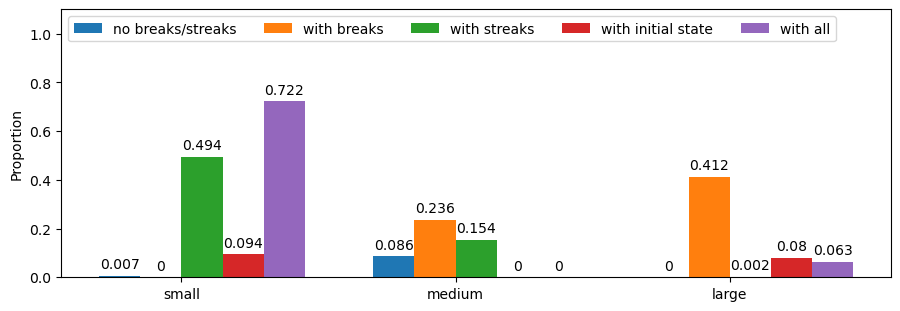

In [252]:
import matplotlib.pyplot as plt
import numpy as np

species = barx
penguin_means = bary
x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9,3))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset - width/2, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion')
# ax.set_title('Number of tasks completed')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 1.1)

plt.show()

## Plot 2:  Transition matrix of successful settings

In [253]:
episode.mdp.transitions[1]

array([[0.        , 0.81818182, 0.45      , 0.18181818],
       [0.81818182, 0.        , 0.45      , 0.18181818],
       [0.45      , 0.45      , 0.        , 0.1       ],
       [0.5       , 0.5       , 0.1       , 0.        ]])

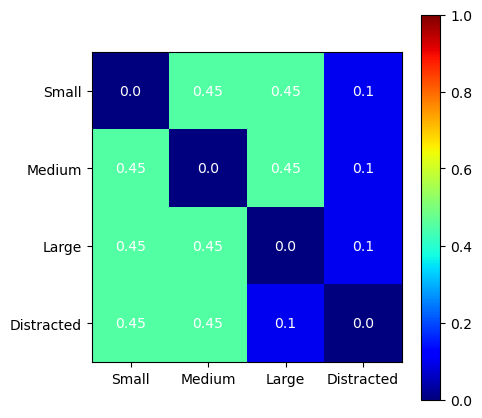

In [242]:
data = episode.mdp.transitions[1]

labels = ["Small", "Medium", "Large", "Distracted"]
f, ax = plt.subplots(1,1,figsize=(5,5))
im = ax.imshow(data, cmap='jet', vmin=0, vmax = 1)
ax.set_xticks(np.arange(4), labels=labels)
ax.set_yticks(np.arange(4), labels=labels)
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, np.around(data[i,j], decimals=2),
                       ha="center", va="center", color="w")
plt.colorbar(im, ax=ax)


 ## Line Plot 3: Sweep across break/streak lengths

In [485]:
self = episode.mdp


get_active_states(self.states)




{0: <__main__.State at 0x15a14b370>,
 1: <__main__.State at 0x15a14bcd0>,
 2: <__main__.State at 0x15a14a740>,
 3: <__main__.State at 0x15a14bbe0>}

In [486]:
self.transitions

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]])}

In [488]:


import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


lengths = [10,20, 30, 40, 50, 60]
# lengths=[10]

t1 = time.time()
initial_state = 0

EP = []

for l in lengths:
    mdp = MDP(Reward, 
              Task_Timer,  
              transitions, 
              initial_state, 
              Break=True,
              break_length = l,
              Streaks=False,
             streak_length=10)

    agent = Agent(epsilon=0.10) # epsilon is the probability of "exploring" vs exploiting
    n_episodes = 1000
    episode = Episodes(mdp, agent, n_episodes)
    episode.run()
    time.time() - t1
    EP.append(episode)

# baryB = get_bary(episode)



    

Running 1000 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -444
	Episode: 2	Score: -352
	Episode: 3	Score: -352
	Episode: 4	Score: -459
	Episode: 5	Score: -441
	Episode: 6	Score: -468
	Episode: 7	Score: -474
	Episode: 8	Score: -343
	Episode: 9	Score: -471
	Episode: 10	Score: -465
	Episode: 11	Score: -474
	Episode: 12	Score: -474
	Episode: 13	Score: -468
	Episode: 14	Score: -459
	Episode: 15	Score: -462
	Episode: 16	Score: -304
	Episode: 17	Score: -453
	Episode: 18	Score: -343
	Episode: 19	Score: -414
	Episode: 20	Score: -340
	Episode: 21	Score: -450
	Episode: 22	Score: -477
	Episode: 23	Score: -14
	Episode: 24	Score: -438
	Episode: 25	Score: -340
	Episode: 26	Score: -355
	Episode: 27	Score: -471
	Episode: 28	Score: -349
	Episode: 29	Score: -358
	Episode: 30	Score: -462
	Episode: 31	Score: -465
	Episode: 32	Score: -474
	Episode: 33	Score: -453
	Episode: 34	Score: -441
	Episode: 35	Score: -480
	Episode: 36	Score: -426
	Episode: 37	Score: -480
	Episode: 38	Score: -346
	Episode: 39	S

/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 52	Score: -474
	Episode: 53	Score: -465
	Episode: 54	Score: -474
	Episode: 55	Score: -349
	Episode: 56	Score: -468
	Episode: 57	Score: -474
	Episode: 58	Score: -477
	Episode: 59	Score: -477
	Episode: 60	Score: -462
	Episode: 61	Score: -343
	Episode: 62	Score: -349
	Episode: 63	Score: -480
	Episode: 64	Score: -465
	Episode: 65	Score: -316
	Episode: 66	Score: -477
	Episode: 67	Score: -358
	Episode: 68	Score: -456
	Episode: 69	Score: -349
	Episode: 70	Score: -480
	Episode: 71	Score: -352
	Episode: 72	Score: -480
	Episode: 73	Score: -235
	Episode: 74	Score: -438
	Episode: 75	Score: -444
	Episode: 76	Score: -444
	Episode: 77	Score: -340
	Episode: 78	Score: -471
	Episode: 79	Score: -480
	Episode: 80	Score: -450
	Episode: 81	Score: -453
	Episode: 82	Score: -462
	Episode: 83	Score: -456
	Episode: 84	Score: -340
	Episode: 85	Score: -456
	Episode: 86	Score: -346
	Episode: 87	Score: -477
	Episode: 88	Score: -453
	Episode: 89	Score: -453
	Episode: 90	Score: -310
	Episode: 91	Score: -468


	Episode: 376	Score: -471
	Episode: 377	Score: -316
	Episode: 378	Score: -462
	Episode: 379	Score: -459
	Episode: 380	Score: -453
	Episode: 381	Score: -352
	Episode: 382	Score: -456
	Episode: 383	Score: -462
	Episode: 384	Score: -477
	Episode: 385	Score: -465
	Episode: 386	Score: -435
	Episode: 387	Score: -468
	Episode: 388	Score: -474
	Episode: 389	Score: -456
	Episode: 390	Score: -462
	Episode: 391	Score: -480
	Episode: 392	Score: -417
	Episode: 393	Score: -456
	Episode: 394	Score: -465
	Episode: 395	Score: -355
	Episode: 396	Score: -477
	Episode: 397	Score: -331
	Episode: 398	Score: -450
	Episode: 399	Score: -456
	Episode: 400	Score: -441
	Episode: 401	Score: -468
	Episode: 402	Score: -459
	Episode: 403	Score: -453
	Episode: 404	Score: -480
	Episode: 405	Score: -459
	Episode: 406	Score: -471
	Episode: 407	Score: -477
	Episode: 408	Score: -349
	Episode: 409	Score: -453
	Episode: 410	Score: -441
	Episode: 411	Score: -468
	Episode: 412	Score: -462
	Episode: 413	Score: -352
	Episode: 41

	Episode: 699	Score: -462
	Episode: 700	Score: -480
	Episode: 701	Score: -337
	Episode: 702	Score: -450
	Episode: 703	Score: -459
	Episode: 704	Score: -477
	Episode: 705	Score: -453
	Episode: 706	Score: -465
	Episode: 707	Score: -343
	Episode: 708	Score: -453
	Episode: 709	Score: -331
	Episode: 710	Score: -319
	Episode: 711	Score: -453
	Episode: 712	Score: -420
	Episode: 713	Score: -217
	Episode: 714	Score: -438
	Episode: 715	Score: -447
	Episode: 716	Score: -346
	Episode: 717	Score: -480
	Episode: 718	Score: -444
	Episode: 719	Score: -453
	Episode: 720	Score: -462
	Episode: 721	Score: -334
	Episode: 722	Score: -334
	Episode: 723	Score: -462
	Episode: 724	Score: -465
	Episode: 725	Score: -334
	Episode: 726	Score: -462
	Episode: 727	Score: -352
	Episode: 728	Score: -477
	Episode: 729	Score: -462
	Episode: 730	Score: -468
	Episode: 731	Score: -456
	Episode: 732	Score: -465
	Episode: 733	Score: -313
	Episode: 734	Score: -477
	Episode: 735	Score: -456
	Episode: 736	Score: -444
	Episode: 73

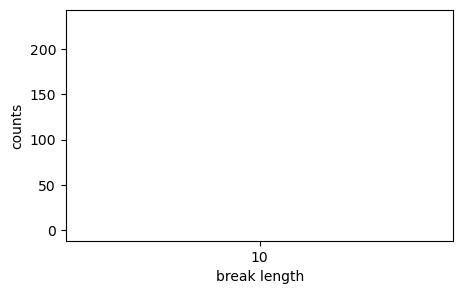

In [489]:
plt.figure(figsize=(5,3))
plt.plot(np.c_[[get_bary(e) for e in EP]])
plt.xticks(np.arange(len(lengths)), lengths)
plt.xlabel("break length")
plt.ylabel("counts")
plt.show()

In [ ]:

# # take 

# barx = ["small", "medium", "large"]





# bar1 = plt.bar(barx, bary, label="no break/streaks")
# plt.legend()
# plt.show()
    


## Random Search

In [ ]:
import random as rand
# n_samples for random search = 4,000
def RandomSearch(transitions, n_samples=4000):
    params = {}
    
    for i in range(n_samples):
        print(i)
        
        initial_state = rand.randrange(0,2)
        Break = bool(rand.getrandbits(1))
        break_length = rand.randrange(5,60,5)
        Streaks = bool(rand.getrandbits(1))
        streak_length = rand.randrange(10,90,5)
        transitions = {0: transitions_0,
               1: []}
        
        offtask = 0.1
        rand_1 = rand.uniform(0, 1-offtask)
        rand_2 = rand.uniform(0, 1-offtask)
        rand_3 = rand.uniform(0, 1-offtask)
        rand_4 = npr.dirichlet(np.ones(3),size=1)[0]
        
        transitions[1] = [[0., rand_1, 1-offtask-rand_1, offtask],
                              [rand_2, 0., 1-offtask-rand_2, offtask],
                              [rand_3, 1-offtask-rand_3, 0., offtask],
                              [rand_4[0], rand_4[1], rand_4[2], 0.]]

        mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
          streak_length=10,
          streak_reward=30)
        print(transitions[1][0][3])
        agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
        n_episodes = 50
        episode = Episodes(mdp, agent, n_episodes)
        episode.run()
        expected_score = np.median(episode.score)
        
        params[i] = {"transition parameter 1": rand_1,
                    "transition parameter 2": rand_2,
                    "transition parameter 3": rand_3,
                    "transition parameter 4": rand_4[0],
                    "transition parameter 5": rand_4[1],
                    "transition parameter 6": rand_4[2],
                    "break": Break,
                    "streaks": Streaks,
                    "break_length": break_length,
                    "streak_length": streak_length,
                    "expected score": expected_score}
        
    return params

In [ ]:
import json

params = RandomSearch(transitions, 4000)
with open("random_search.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

In [ ]:
expected_score = np.median(episode.score)
print(expected_score)

In [ ]:

# build a dictionary of dictionaries
# key is the "experiment", item is another dictionary of the parameters


{0: {"transition parameter 1": 0.6
    "transition parameter 2":0.3
    "transition parameter 3": 0.2
    "transition parameter 4": 0.1
    "transition parameter 5": 0.4
    "break": True/False,
    "streaks": True/False,
    "break_length": 20,
    "streak_length": 30,
    "expected score": -100},
1: ,
2:,
}



In [ ]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:
# print(test.prog)
# print(test.actions)
# print(test.states)
# print(test.rewards)
# print(test.on_break)


In [ ]:
#  simple episode
# prog = []
# actions = []
# states = []
# rewards = []
# on_break = []
# on_break2 = []
# time_horizon = 480

# # get initial state/ set reward to 0
# s0 = mdp.get_state_ix()
# # s0 = mdp.get_state()
# r = 0
# agent = Agent()
# for i in range(time_horizon):
# #     a = fake_agent(s0, r)
# #     a = agent(s0, r)
    
#     a = agent.choose_action(s0)
#     s1, r = mdp(a)
#     s1 = mdp.get_state_ix()
#     agent.update(s0, s1, r)

#     # Q update
# #     break
    
#     s0 = s1

    
#     p_ = [self.states[k].progress for k in range(4)]
    
#     prog.append(p_)
#     actions.append(a)
#     states.append(self.current_state_ix)
#     rewards.append(r)
#     on_break.append(self.on_break)
#     on_break2.append(self.task_timer.on_break)
    
    
#     active_states = get_active_states(self.states,True)
#     if len(active_states) == 1:
#         break


# print(f'a:\t{a}')
# print(print_progress(self.states))

In [ ]:

f, axs = plt.subplots(5,1, figsize=(10,7), sharex=True)

# index the episode you want to visualize
ep = 0

axs[0].plot(episode.states[ep])
axs[0].set_ylabel('states')
axs[1].plot(episode.actions[ep])
axs[1].set_ylabel('actions')
axs[2].plot(np.array(episode.prog[ep])[:,:-1])
axs[2].set_ylabel('progress')
axs[3].plot(np.cumsum(episode.rewards[ep]))
axs[3].set_ylabel('total rewards')
axs[4].plot(episode.on_break[ep])
axs[4].set_ylabel('on break')

# axs[3].set_yscale('log')

plt.show()

In [ ]:
agent.Qp